関数の定義と必要なモジュールの読み込み

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#計算に必要な関数の定義
def Cal_Ites(Vout, Xi):
  '''
  Vout is out put voltage of SQUID
  Xi is the current-voltage conversion coefficient
  '''
  Ites = Vout / Xi
  return Ites

def Cal_Rtes(Itb, Ites, Rsh):
  '''
  Itb is TES bias current (unit:A)
  Ites is TES current (unit:A)
  Rsh is shunt Resistance (unit:Ohm)
  '''
  Rtes = (Itb - Ites) * Rsh / Ites
  return Rtes

def Cal_Vtes(Rtes, Ites):
  return Rtes * Ites

def Cal_Ttes(Tbath, Go, n, Ptes):
  return ((Tbath**(n)) + ((n * Ptes) / Go))**(1 / n)

def Cal_Gtes(Go,n,Ttes):
  return Go * (Ttes**(n-1))

def makeTbath(filename_list):
  Tbath = []
  num = 0
  for tb in filename_list:
    tb_ = tb.split('/')[-1]
    for e, name in enumerate(tb_.split('_')):
      if name.find('mK')!=-1:
        num = e

    tb_key = tb_.split('_')[num]
    tbath = float(tb_key[:-2])
    Tbath.append(tbath)

  Tbath = np.asarray(Tbath)
  print(Tbath)
  return Tbath

def Cal_alpha(T, R):
  dR = np.diff(R)
  dT = np.diff(T)
  dRdT = dR/dT
  T_ave = (T[1:] + T[:-1])/2
  R_ave = (R[1:] + R[:-1])/2
  alpha = dRdT * T_ave / R_ave
  return alpha

def OffsetCollection(Vsq,nofit=False):
  dVsq = np.diff(Vsq)
  vsq  = Vsq
  edge_num = 0
  for thr in np.arange(3.0,0.005,-0.001):
    mask = dVsq>thr
    if len(dVsq[mask])==1:
      print(f'threshold value {thr}')
      edge_num = np.argwhere(mask==True)+1
      edge_num = edge_num[0][0]
      print(edge_num)
      break

  if (edge_num!=0)and(nofit):
    print('collect offset')
    ss     = vsq[edge_num:]
    ss     = ss - ss.min()
    ns     = vsq[:edge_num]
    ns_Itb = Itb[:edge_num]
    a, b   = np.polyfit(ns_Itb[:200], ns[:200], 1)
    ns     = ns - b
    Vsqc = np.hstack((ns, ss))
  else:
    Vsqc = vsq-vsq.min()

  return Vsqc

In [4]:
#データの読み込み
filename_list = glob.glob('230918/*.txt')
filename_list.sort()
filename_list

['230918/IV_070mK_20230918.txt',
 '230918/IV_075mK_20230918.txt',
 '230918/IV_080mK_20230918.txt',
 '230918/IV_085mK_20230918.txt',
 '230918/IV_090mK_20230918.txt',
 '230918/IV_095mK_20230918.txt',
 '230918/IV_100mK_20230918.txt',
 '230918/IV_105mK_20230918.txt',
 '230918/IV_110mK_20230918.txt',
 '230918/IV_115mK_20230918.txt',
 '230918/IV_120mK_20230918.txt',
 '230918/IV_125mK_20230918.txt',
 '230918/IV_130mK_20230918.txt',
 '230918/IV_135mK_20230918.txt',
 '230918/IV_140mK_20230918.txt',
 '230918/IV_145mK_20230918.txt',
 '230918/IV_150mK_20230918.txt',
 '230918/IV_155mK_20230918.txt',
 '230918/IV_160mK_20230918.txt',
 '230918/IV_165mK_20230918.txt',
 '230918/IV_170mK_20230918.txt',
 '230918/IV_175mK_20230918.txt',
 '230918/IV_180mK_20230919.txt',
 '230918/IV_185mK_20230919.txt',
 '230918/IV_190mK_20230919.txt',
 '230918/IV_195mK_20230919.txt',
 '230918/IV_200mK_20230919.txt',
 '230918/IV_205mK_20230919.txt',
 '230918/IV_210mK_20230919.txt',
 '230918/IV_215mK_20230919.txt',
 '230918/I

In [5]:
Tbath = makeTbath(filename_list)

[ 70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235.]


In [ ]:
Rsh = 3.9e-3 #Ohm
# Min = 1.009e-10
# Mfb = 8.912e-11
# Rfb = 30.e3
Rfb = 100.e3
# Xi = Rfb * Min / Mfb
Xi = Rfb
xi_collect = 1.0

data = {}
Vout = {}
Itb  = {}
Ites = {}
Vtes = {}
Rtes = {}
Ptes = {}
Gtes = {}
Ttes = {}

for e, i in enumerate(filename_list):
  k = Tbath[e]
  data    = np.loadtxt(i)
  data_num = len(data[:,0])
  Itb[k]  = data[:,0]/1e6 #A
  Vout[k] = data[:,1] - data.min() #V
  Ites[k]  = Cal_Ites(Vout[k], Xi)
  Rtes[k] = Cal_Rtes(Itb[k], Ites[k], Rsh)
  Vtes[k] = Cal_Vtes(Rtes[k], Ites[k])
  Ptes[k] = Ites[k] * Vtes[k]
  if e == 0:
    #超伝導での傾きを求める、超伝導部分の10点を持ってきてdI,dVの平均値からdI/dVを計算する
    tilt = np.average(np.diff(Ites[k][data_num-11:data_num-1]))/np.average(np.diff(Vtes[k][data_num-11:data_num-1]))
    print(k)
    print(tilt)
    while tilt > 0: #傾きが負になるようにXiを正にするように補正
      Xi -= 1
      Ites[k]  = Cal_Ites(Vout[k], Xi)
      Rtes[k] = Cal_Rtes(Itb[k], Ites[k], Rsh)
      Vtes[k] = Cal_Vtes(Rtes[k], Ites[k])
      tilt = np.average(np.diff(Ites[k][data_num-11:data_num-1]))/np.average(np.diff(Vtes[k][data_num-11:data_num-1]))

    while tilt < 0: #傾きが正になるようにXiを正にするように補正
      Xi += 1
      Ites[k]  = Cal_Ites(Vout[k], Xi)
      Rtes[k] = Cal_Rtes(Itb[k], Ites[k], Rsh)
      Vtes[k] = Cal_Vtes(Rtes[k], Ites[k])
      tilt = np.average(np.diff(Ites[k][data_num-11:data_num-1]))/np.average(np.diff(Vtes[k][data_num-11:data_num-1]))


    print(Xi)
    print(tilt)
    Ptes[k] = Ites[k] * Vtes[k]

  Ites[k]  = Cal_Ites(Vout[k], Xi)
  Rtes[k] = Cal_Rtes(Itb[k], Ites[k], Rsh)
  Vtes[k] = Cal_Vtes(Rtes[k], Ites[k])
  Ptes[k] = Ites[k] * Vtes[k]

70.0
64.00114054495299
100000.0
64.00114054495299


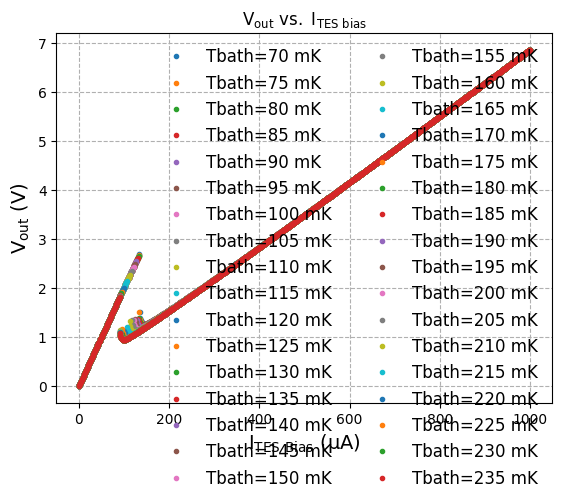

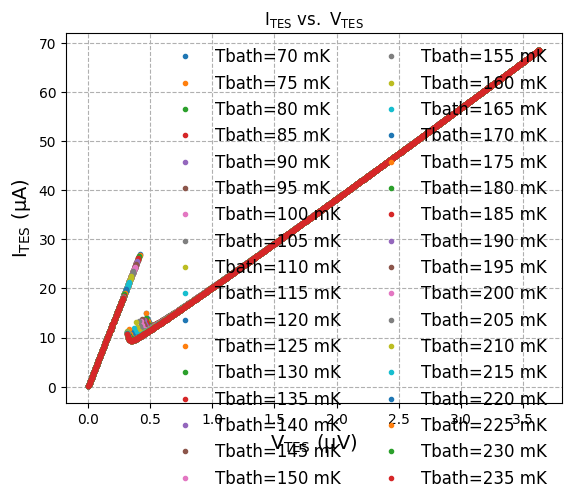

In [27]:
#plot row data
plt.figure(1)
for i in Tbath:
  plt.plot(Itb[i]*1e6, Vout[i], '.', label='Tbath='+str(int(i))+' mK')

plt.title(r'$\rm V_{out}\ vs.\ I_{TES\ bias}$')
plt.xlabel(r'$\rm I_{TES\ Bias}\ (\mu A)$', fontsize=14)
plt.ylabel(r'$\rm V_{out}\ (V)$', fontsize=14)
plt.legend(fontsize=12,frameon=False, ncols=2)
plt.grid(ls='--')
plt.show()

#plot Ites vs. Vtes
plt.figure(2)
for i in Tbath:
  plt.plot(Vtes[i]*1e6, Ites[i]*1e6, '.', label='Tbath='+str(int(i))+' mK')

plt.title(r'$\rm I_{TES}\ vs.\ V_{TES}$')
plt.xlabel(r'$\rm V_{TES}\ (\mu V)$', fontsize=14)
plt.ylabel(r'$\rm I_{TES}\ (\mu A)$', fontsize=14)
plt.legend(fontsize=12,frameon=False, ncols=2)
plt.grid(ls='--')
plt.show()

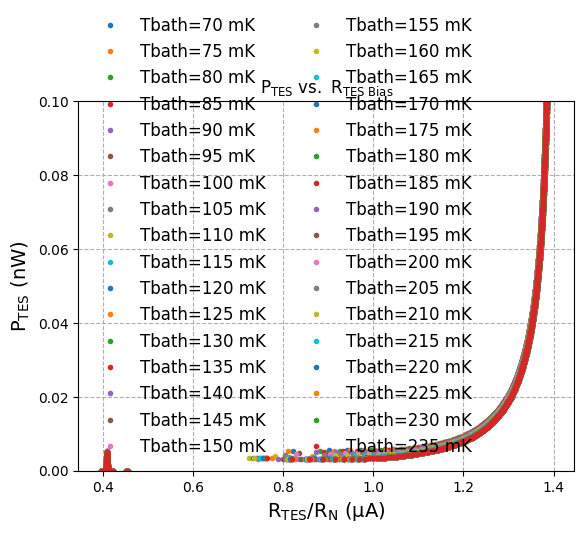

In [32]:
#plot Ptes vs. Itb
plt.figure()
for e, tb_key in enumerate(Tbath):
  rtes = Rtes[tb_key][Rtes[tb_key]==Rtes[tb_key]]
  rtesmax = rtes.max()
  rtesmin = rtes.min()
  Rn = rtesmax - rtesmin
  plt.plot(Rtes[tb_key]/Rn, Ptes[i]*1e9, '.', label='Tbath='+str(int(tb_key))+' mK')

plt.title(r'$\rm P_{TES}\ vs.\ R_{TES\ Bias}$')
plt.xlabel(r'$\rm R_{TES}/R_{N}\ (\mu A)$', fontsize=14)
plt.ylabel(r'$\rm P_{TES}\ (nW)$', fontsize=14)
plt.legend(fontsize=12,frameon=False, ncols=2)
plt.grid(ls='--')
plt.ylim(0., 0.1)
#plt.xlim(0., 300)
plt.show()

 - Adding parameter "Tc"
 - Adding parameter "Go"
 - Adding parameter "n"
[[Model]]
    Model(Pfunc)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 102
    # data points      = 34
    # variables        = 3
    chi-square         = 1.3463e-23
    reduced chi-square = 4.3429e-25
    Akaike info crit   = -1904.40755
    Bayesian info crit = -1899.82847
    R-squared          = 0.99999999
[[Variables]]
    Tc:  0.31999843 +/- 0.13076954 (40.87%) (init = 0.29)
    Go:  4.7949e-10 +/- 3.6266e-10 (75.64%) (init = 1e-08)
    n:   3.00000000 +/- 12666.9226 (422230.75%) (init = 3.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(Go, n)  = +0.9960
    C(Tc, Go) = +0.9543
    C(Tc, n)  = +0.9243


/var/folders/db/5nxktxt15vg9dgh7_nb5_y8w0000gn/T/ipykernel_40208/3126574227.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14,frameon=False)


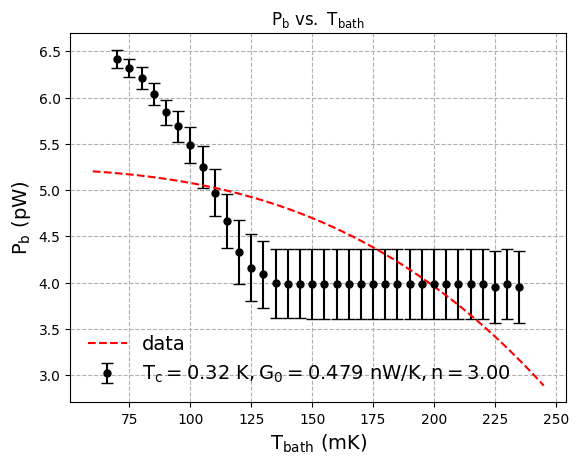

In [29]:
#Calculation Tc, Go, n
import lmfit as lmf

def Pfunc(Tb, Tc, Go, n):
  '''
  Tbath: unit K
  Tc: unit K
  Go: unit W/K
  n:
  '''
  pb = (Go/n)*( pow(Tc,n) - pow(Tb,n) )
  return pb

Pb = []
Pberr = []
for e, tb_key in enumerate(Tbath):
  rtes_ = Rtes[tb_key][Rtes[tb_key]==Rtes[tb_key]]
  rtesmax = rtes_.max()
  rtesmin = rtes_.min()
  Rn = Rn = rtesmax - rtesmin
  rtes = Rtes[tb_key]/Rn

  #Rtes/Rnの値が20%-30%を持ってくる
  filter_Ptes = (1.0<rtes) & (rtes<1.1)

  pb = np.average(Ptes[tb_key][filter_Ptes])
  Pb.append(pb)

  #各Tbath温度でPbを計算した際のデータの不偏標準偏差から誤差を計算する。
  perr = np.std(Ptes[tb_key][filter_Ptes],ddof = 1)
  Pberr.append(perr)

#
Tb = Tbath/1e3     #mK to K
Pb = np.asarray(Pb) #W
Pberr = np.asarray(Pberr)

#Fitting
model = lmf.Model(Pfunc)
model.make_params(verbose=True)
model.set_param_hint('Tc',min=0.100, max=0.320)
model.set_param_hint('Go',min=1.e-15, max=1.e2)
model.set_param_hint('n' ,min=3, max=4)
result = model.fit(Pb, Tb=Tb, Tc=0.290, Go=1.e-8, n=3.5)
print(result.fit_report())
Tc = result.best_values['Tc']
Go = result.best_values['Go']
n  = result.best_values['n']

#χ2の計算
chi2_min = sum(((Pb - Pfunc(Tb=Tb, Tc=Tc, Go=Go, n=n))/Pberr)**2)

#plot Pb vs. Tbath
plt.figure()
plt.errorbar(Tb*1e3, Pb*1e12, yerr = Pberr*1e12, color='k',capsize=4,ms=5,marker='o',mec='k',mfc='k',ls='None')
tb_min = Tbath.min()/1e3 - 0.010
tb_max = Tbath.max()/1e3 + 0.010
x = np.linspace(tb_min, tb_max, 100) #for plotting model
plt.plot(x*1e3, Pfunc(x, Tc, Go, n)*1e12, 'r--')
plt.title(r'$\rm P_{b}\ vs.\ T_{bath}$')
plt.xlabel(r'$\rm T_{bath}\ (mK)$', fontsize=14)
plt.ylabel(r'$\rm P_{b}\ (pW)$', fontsize=14)
plt.legend(fontsize=14,frameon=False)
plt.grid(ls='--')
plt.legend(['data',rf'$\rm T_c={Tc:.3}\ K, G_{0}={Go*1e9:.3}\ nW/K, n={n:.2f}$'],fontsize=14,frameon=False)
plt.show()

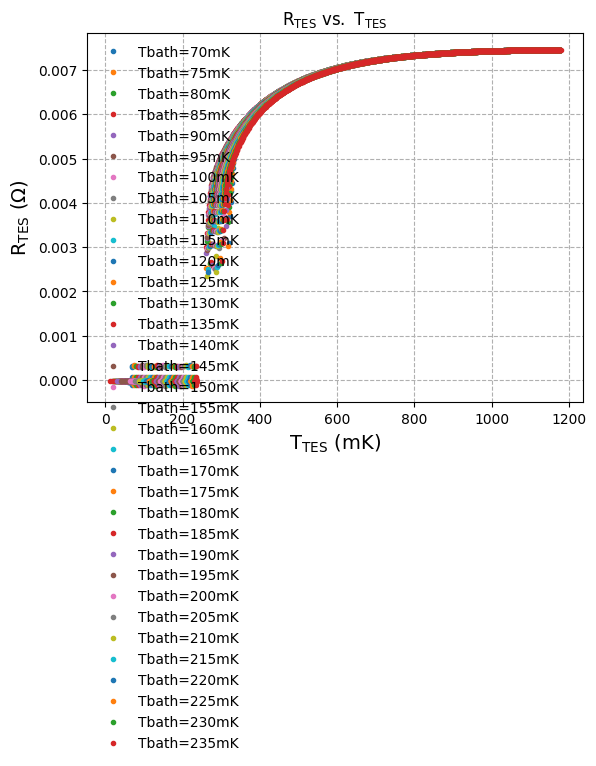

In [14]:
#Calculation T_TES
for i in Tbath:
  Ttes[i] = Cal_Ttes(i/1e3, Go, n, Ptes[i])
  plt.plot(Ttes[i]*1e3, Rtes[i], '.',label='Tbath='+str(int(i))+'mK')

plt.title(r'$\rm R_{TES}\ vs.\ T_{TES}$')
plt.xlabel(r'$\rm T_{TES}\ (mK)$', fontsize=14)
plt.ylabel(r'$\rm R_{TES}\ (\Omega)$', fontsize=14)
plt.legend(fontsize=10,frameon=False, ncol=1,loc=2)
plt.grid(ls='--')

他にもGtesやαなどが計算できるので、関数を使ってプロットしてみるといい。

(150.0, 300.0)

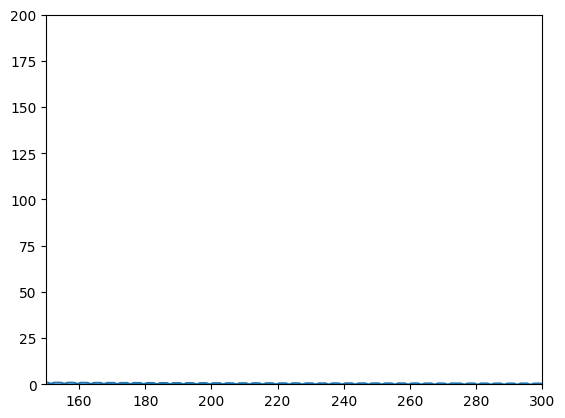

In [20]:
alpha = Cal_alpha(Ttes[120], Rtes[120])
x = (Itb[120][1:] + Itb[120][:-1])/2
plt.plot(x[alpha==alpha]*1e6, alpha[alpha==alpha])
plt.ylim(0, 200)
plt.xlim(150,300)

コントアを計算

In [21]:
import numpy as np
import matplotlib.pyplot as plt

#68%,90%,99%誤差
CRange68=2.295815160785974337606
CRange90=4.605170185988091368036
CRange99=9.210340371976182736072
cslevels=[CRange68,CRange90,CRange99]
cmap = plt.get_cmap("tab10")
fn = [r'$68.27\%$',r'$90\%$',r'$99\%$']

def Pfunc(Tb, Tc, Go, n):
  '''
  Tbath: unit K
  Tc: unit K
  Go: unit W/K
  n:
  '''
  pb = (Go/n)*( pow(Tc,n) - pow(Tb,n) )
  return pb

#コントアの計算用関数
def CalCont_Govsn(Tb, Pb, Perr, Tcbest, chi2_min, xn=np.arange(2.0, 4.1, 0.1), yg=np.arange(20, 31, 1), name=None):

  #G0 vs n
  Xn, YGo = np.meshgrid(xn, yg)
  for e, nn in enumerate(xn):
      chi2_Fix_n = np.array([])
      for j, g0 in enumerate(yg):
          g0 = g0*1e-9 #nW/k -> W/K
          #chi2を計算
          chi2_cont = sum(((Pb - Pfunc(Tb=Tb, Tc=Tc, Go=g0, n=nn))/Perr)**2)
          #print(f'\r{e+1}/{len(X[0])},{j+1}/{len(Y.T[0])}',end='',flush=True)
          print(f'\r{e+1}/{len(X[0])}',end='',flush=True)

          chi2_Fix_n = np.hstack((chi2_Fix_n, chi2_cont))

      if e == 0:
        chi2_array = chi2_Fix_n
      else:
        chi2_array = np.vstack((chi2_array, chi2_Fix_n))

  chi2_array -= chi2_min

  plt.figure()
  cont = plt.contour(Xn, YGo, chi2_array.T, levels=cslevels)
  cont.clabel(fmt='%1.1f', fontsize=14)
  plt.plot(n, Go*1e9, 'r*', ms=10)
  plt.ylabel(r'$G_{\rm 0}\ (\rm nW/K)$', fontsize=14)
  plt.xlabel(r'$n$', fontsize=14)
  if name:
      np.savetxt(f'G0vsn_X_{name}.txt',X)
      np.savetxt(f'G0vsn_Y_{name}.txt',Y)
      np.savetxt(f'G0vsn_Z_{name}.txt',chi2_array)
      #np.savetxt(f'BestFit_{name}.txt', bestfit_para)

def CalCont_Tcvsn(Tb, Pb, Perr, Gobest, chi2_min, xn=np.arange(2.0, 4.1, 0.1), ytc=np.arange(150, 170, 1), name=None):

  #G0 vs n
  Xn, Ytc = np.meshgrid(xn, ytc)
  for e, nn in enumerate(xn):
      chi2_Fix_n = np.array([])
      for j, tc in enumerate(ytc):
          tc = tc*1e-3 # mK -> K
          #chi2を計算
          chi2_cont = sum(((Pb - Pfunc(Tb=Tb, Tc=tc, Go=Go, n=nn))/Perr)**2)
          print(f'\r{e+1}/{len(X[0])},{j+1}/{len(Y.T[0])}',end='',flush=True)
          #print(f'\r{e+1}/{len(X[0])}',end='',flush=True)

          chi2_Fix_n = np.hstack((chi2_Fix_n, chi2_cont))

      if e == 0:
        chi2_array = chi2_Fix_n
      else:
        chi2_array = np.vstack((chi2_array, chi2_Fix_n))

  chi2_array -= chi2_min

  plt.figure()
  cont = plt.contour(Xn, Ytc, chi2_array.T, levels=cslevels)
  cont.clabel(fmt='%1.1f', fontsize=14)
  plt.plot(n, Tc*1e3, 'r*', ms=10)
  plt.ylabel(r'$T_{\rm c}\ (\rm mK)$', fontsize=14)
  plt.xlabel(r'$n$', fontsize=14)
  if name:
      np.savetxt(f'Tcvsn_X_{name}.txt',X)
      np.savetxt(f'Tcvsn_Y_{name}.txt',Y)
      np.savetxt(f'Tcvsn_Z_{name}.txt',chi2_array)
      #np.savetxt(f'BestFit_{name}.txt', bestfit_para)

def CalCont_TcvsGo(Tb, Pb, Perr, nbest, chi2_min, xg=np.arange(20, 31, 1), ytc=np.arange(150, 170, 1), name=None):

  #G0 vs n
  Xgo, Ytc = np.meshgrid(xg, ytc)
  for e, g0 in enumerate(xg):
      chi2_Fix_n = np.array([])
      for j, tc in enumerate(ytc):
          tc = tc*1e-3 # mK -> K
          #chi2を計算
          chi2_cont = sum(((Pb - Pfunc(Tb=Tb, Tc=tc, Go=g0, n=n))/Perr)**2)
          print(f'\r{e+1}/{len(X[0])},{j+1}/{len(Y.T[0])}',end='',flush=True)
          #print(f'\r{e+1}/{len(X[0])}',end='',flush=True)

          chi2_Fix_n = np.hstack((chi2_Fix_n, chi2_cont))

      if e == 0:
        chi2_array = chi2_Fix_n
      else:
        chi2_array = np.vstack((chi2_array, chi2_Fix_n))

  chi2_array -= chi2_min

  plt.figure()
  cont = plt.contour(Xgo, Ytc, chi2_array.T, levels=cslevels)
  cont.clabel(fmt='%1.1f', fontsize=14)
  plt.plot(Go*1e9, Tc*1e3, 'r*', ms=10)
  plt.ylabel(r'$T_{\rm c}\ (\rm mK)$', fontsize=14)
  plt.xlabel(r'$G_{0}\ (\rm nW/K)$', fontsize=14)
  if name:
      np.savetxt(f'TcvsGo_X_{name}.txt',X)
      np.savetxt(f'TcvsGo_Y_{name}.txt',Y)
      np.savetxt(f'TcvsGo_Z_{name}.txt',chi2_array)
      #np.savetxt(f'BestFit_{name}.txt', bestfit_para)

In [22]:
path = '/content/drive/MyDrive/GraduationResearch/1mushroom/JAXA120_Ea4_A5/IV/'

ID = 'A5'
best_fit_para = np.array([Tc, Go, n, chi2_min])
sdata = np.array([Tb, Pb, Pberr])
np.savetxt(path+f'{ID}_data_bestfitpara.txt',best_fit_para,header='Tc(K), G0(W/K), n, chi2_min')
np.savetxt(path+f'{ID}_data_PbTb.txt',sdata,header='Tbath(K), Pb(W), Pb err(W)')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/GraduationResearch/1mushroom/JAXA120_Ea4_A5/IV/A5_data_bestfitpara.txt'

41/100,40/200

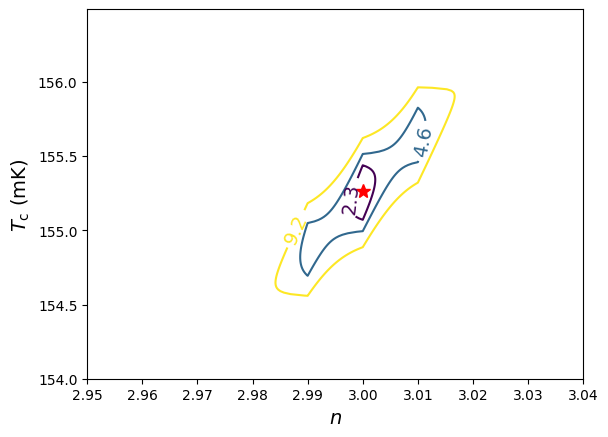

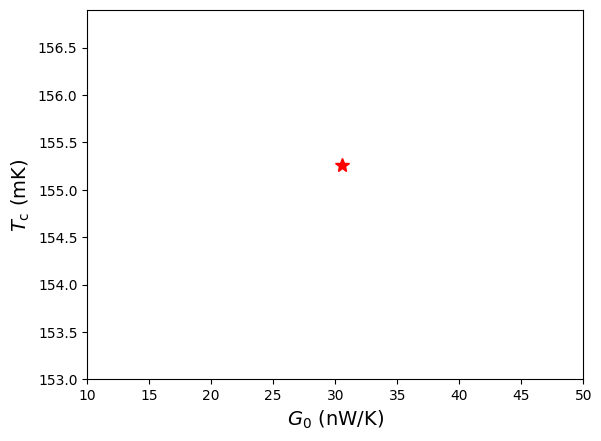

In [ ]:
#TbとPb,Pberrのデータ読み込み
Tb, Pb, Pberr = np.loadtxt(path+f'{ID}_data_PbTb.txt')
Tc, Go, n, chi2_min = np.loadtxt(path+f'{ID}_data_bestfitpara.txt')
#コントアの計算
#CalCont_Govsn(Tb, Pb, Pberr, Tc, chi2_min, xn=np.arange(2.5, 3.5, 0.01), yg=np.arange(20, 40, 0.1))
CalCont_Tcvsn(Tb, Pb, Pberr, Go, chi2_min, xn=np.arange(2.95, 3.05, 0.01), ytc=np.arange(154, 156.5, 0.01))
CalCont_TcvsGo(Tb, Pb, Pberr, n, chi2_min, xg=np.arange(10, 51, 1), ytc=np.arange(153, 157, 0.1))

In [30]:
print(Pb)
print(Pberr)

[6.41965187e-12 6.32091334e-12 6.21078813e-12 6.04295998e-12
 5.84034416e-12 5.68850680e-12 5.48647488e-12 5.25057837e-12
 4.97260979e-12 4.66398663e-12 4.33343517e-12 4.16346799e-12
 4.09022303e-12 3.99267228e-12 3.98845499e-12 3.98789823e-12
 3.98654201e-12 3.98632495e-12 3.98603290e-12 3.98528189e-12
 3.98567697e-12 3.98483215e-12 3.98474492e-12 3.98458041e-12
 3.98486684e-12 3.98503959e-12 3.98520387e-12 3.98531061e-12
 3.98530450e-12 3.98506849e-12 3.98468660e-12 3.95652208e-12
 3.98459095e-12 3.95708212e-12]
[9.88379613e-14 9.94477556e-14 1.15280749e-13 1.18813494e-13
 1.35427557e-13 1.70172022e-13 1.91328612e-13 2.27667967e-13
 2.53822948e-13 2.94965819e-13 3.46315445e-13 3.58940492e-13
 3.59777705e-13 3.72783711e-13 3.74296379e-13 3.74448021e-13
 3.74955977e-13 3.74961039e-13 3.75100916e-13 3.75243083e-13
 3.75277194e-13 3.75400875e-13 3.75439547e-13 3.75607127e-13
 3.75484794e-13 3.75386517e-13 3.75330809e-13 3.75298400e-13
 3.75148163e-13 3.75374973e-13 3.75418124e-13 3.89746